In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [85]:
def get_k_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eig(hamiltonian.to_matrix())[0]
    print(sorted(eigen_values))
    
    return sorted(eigen_values)[0]

In [86]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_k_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [80]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [25]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

In [26]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:03,  8.69it/s]
27it [00:01, 13.70it/s]
27it [00:01, 14.42it/s]
27it [00:01, 17.86it/s]
27it [00:01, 16.08it/s]
27it [00:01, 17.25it/s]
27it [00:02, 12.90it/s]
27it [00:01, 13.77it/s]
27it [00:01, 17.10it/s]
27it [00:01, 14.58it/s]
27it [00:01, 16.10it/s]
27it [00:01, 14.02it/s]
27it [00:01, 15.42it/s]
27it [00:01, 15.06it/s]
27it [00:01, 16.11it/s]
27it [00:01, 14.69it/s]
27it [00:01, 18.13it/s]
27it [00:01, 21.24it/s]
27it [00:01, 20.94it/s]
27it [00:01, 22.38it/s]
27it [00:01, 21.74it/s]
27it [00:01, 22.10it/s]
27it [00:01, 17.74it/s]
27it [00:02, 12.88it/s]
27it [00:01, 14.60it/s]
27it [00:01, 14.92it/s]
27it [00:01, 13.96it/s]
27it [00:01, 13.59it/s]
27it [00:01, 14.84it/s]
27it [00:01, 13.81it/s]
27it [00:01, 14.33it/s]
27it [00:01, 17.54it/s]
27it [00:01, 18.93it/s]
27it [00:01, 17.05it/s]
27it [00:01, 17.65it/s]
27it [00:01, 17.84it/s]
27it [00:01, 17.36it/s]
27it [00:01, 17.12it/s]
27it [00:01, 18.22it/s]
27it [00:01, 18.32it/s]
27it [00:01, 17.43it/s]
27it [00:01, 16.

[2.23776209 4.19703165 5.72566213 4.18769754 3.45618209 0.70731528
 5.52569681 3.86871839 0.60659777 4.87434593 1.63402089 1.14453482
 3.997679   3.97987538 2.91959888 5.72794196 3.29608353 1.8271363
 4.93328896 0.37551204 3.61768055 4.10934598 0.5583078  4.51172399
 4.46528203 1.82566185 4.76189085 1.94447312 1.75393754 6.52519522
 4.87588992 0.1156331 ]


27it [00:01, 16.87it/s]

CPU times: total: 1min 18s
Wall time: 1min 25s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

In [27]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
Exact Eigenvalue:
(-6.769813218087976+0j)

Approximated Eigenvalue:
-7.6879187852843165

Approximation Error
0.13561756249689327


In [28]:
print(approximated_energies)
approximated_energies = []

[-7.445905259690404, -7.369503803860725, -7.482720117730408, -7.373399172513441, -7.409594362647777, -7.4370465313483995, -7.391269757941298, -7.465987968757013, -7.491689073558223, -7.468590506529826, -7.301716463004188, -7.477928314477381, -7.577642977423942, -7.59652752122234, -7.555166424163128, -7.594544124447909, -7.547592427201686, -7.612685551394323, -7.620341131947522, -7.595334769142927, -7.584115669503708, -7.616279743172608, -7.568532975871534, -7.617188693018664, -7.63022882078974, -7.620529081833595, -7.593219182303089, -7.613806600480836, -7.605717979506298, -7.615973802885564, -7.636031161476244, -7.629059374680143, -7.621887761403372, -7.605510117268224, -7.605067223704315, -7.509855618072003, -7.578450298213291, -7.609845285059333, -7.625879198609012, -7.57222661176104, -7.623370760988461, -7.658072618148456, -7.663884485472507, -7.6481432594961305, -7.634843176585518, -7.612551866543608, -7.631345563021724, -7.686069003289018, -7.673955009698928, -7.632158991579372]


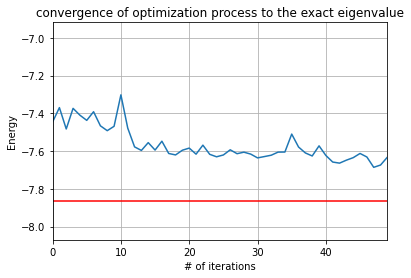

In [87]:
LiH_approximated_energies = [-7.445905259690404, -7.369503803860725, -7.482720117730408, -7.373399172513441, -7.409594362647777, -7.4370465313483995, -7.391269757941298, -7.465987968757013, -7.491689073558223, -7.468590506529826, -7.301716463004188, -7.477928314477381, -7.577642977423942, -7.59652752122234, -7.555166424163128, -7.594544124447909, -7.547592427201686, -7.612685551394323, -7.620341131947522, -7.595334769142927, -7.584115669503708, -7.616279743172608, -7.568532975871534, -7.617188693018664, -7.63022882078974, -7.620529081833595, -7.593219182303089, -7.613806600480836, -7.605717979506298, -7.615973802885564, -7.636031161476244, -7.629059374680143, -7.621887761403372, -7.605510117268224, -7.605067223704315, -7.509855618072003, -7.578450298213291, -7.609845285059333, -7.625879198609012, -7.57222661176104, -7.623370760988461, -7.658072618148456, -7.663884485472507, -7.6481432594961305, -7.634843176585518, -7.612551866543608, -7.631345563021724, -7.686069003289018, -7.673955009698928, -7.632158991579372]
plot_convergence_of_optimization_process(LiH_approximated_energies, exact_eigenvalue=-7.862773163027979,margin=1)

In [30]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:01, 17.46it/s]
27it [00:01, 17.20it/s]
27it [00:01, 17.32it/s]
27it [00:01, 17.31it/s]
27it [00:01, 17.75it/s]
27it [00:01, 17.75it/s]
27it [00:01, 17.42it/s]
27it [00:01, 18.20it/s]
27it [00:01, 17.05it/s]
27it [00:01, 18.52it/s]
27it [00:01, 18.22it/s]
27it [00:01, 17.86it/s]
27it [00:01, 16.39it/s]
27it [00:01, 15.55it/s]
27it [00:01, 16.29it/s]
27it [00:01, 17.22it/s]
27it [00:01, 18.18it/s]
27it [00:01, 16.06it/s]
27it [00:01, 18.29it/s]
27it [00:01, 17.72it/s]
27it [00:01, 16.83it/s]
27it [00:01, 18.63it/s]
27it [00:01, 16.64it/s]
27it [00:01, 17.57it/s]
27it [00:01, 17.93it/s]
27it [00:01, 17.70it/s]
27it [00:01, 17.09it/s]
27it [00:01, 17.93it/s]
27it [00:01, 17.42it/s]
27it [00:01, 17.65it/s]
27it [00:01, 16.14it/s]
27it [00:01, 13.94it/s]
27it [00:01, 15.78it/s]
27it [00:01, 18.06it/s]
27it [00:01, 17.70it/s]
27it [00:01, 18.42it/s]
27it [00:01, 17.77it/s]
27it [00:01, 16.16it/s]
27it [00:01, 18.12it/s]
27it [00:01, 15.33it/s]
27it [00:01, 18.35it/s]
27it [00:01, 18.

[3.63479167 3.77629114 4.50741693 2.22731502 5.98322416 0.5888742
 6.49397925 6.22042702 5.71526561 2.69810595 6.24711253 5.78915951
 2.50339891 2.83807222 1.86403811 2.05333195 0.23559386 2.51578304
 2.59406084 1.53844142 4.15005687 6.35314919 2.48916469 5.89349308
 5.92783229 2.41366812 4.31466794 2.28929575 3.9969203  3.57494724
 1.20129492 0.31091639]


27it [00:01, 17.28it/s]

CPU times: total: 1min 15s
Wall time: 1min 19s


In [31]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
Exact Eigenvalue:
(-6.769813218087976+0j)

Approximated Eigenvalue:
-7.744533942920208

Approximation Error
0.14398044575704352


In [32]:
print(approximated_energies)
approximated_energies = []

[-7.624363947244564, -7.669568040465834, -7.5618269765189705, -7.688836412299139, -7.678843158026712, -7.671477333611768, -7.680571482240487, -7.717654819070679, -7.704275784942458, -7.658257304906172, -7.612817760277535, -7.709458359220965, -7.66210406350105, -7.671702916173217, -7.712343706594842, -7.708103256242304, -7.6954697588388035, -7.589350812448022, -7.677035967822722, -7.668909926216251, -7.714696066057195, -7.674024358522761, -7.6431224727013145, -7.675730721818284, -7.6709775472097395, -7.73263123710716, -7.698262428331602, -7.706111255521946, -7.714077948434402, -7.7170223250966705, -7.721353354144006, -7.728814795634299, -7.710134796158922, -7.68397707951933, -7.697261974506812, -7.681983947612262, -7.720281305678348, -7.707432274229783, -7.728158891414989, -7.7193396109272845, -7.73929159346888, -7.732538103123307, -7.6784483717918945, -7.7246775721118075, -7.754134482998571, -7.74544701361486, -7.742000892210628, -7.745974761783115, -7.743458274419494, -7.7371417976456

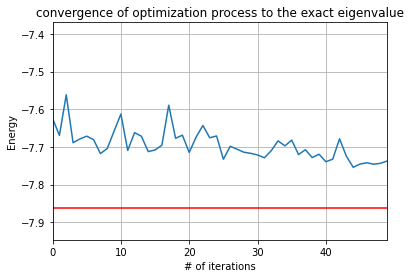

In [88]:
LiH_approximated_energies = [-7.624363947244564, -7.669568040465834, -7.5618269765189705, -7.688836412299139, -7.678843158026712, -7.671477333611768, -7.680571482240487, -7.717654819070679, -7.704275784942458, -7.658257304906172, -7.612817760277535, -7.709458359220965, -7.66210406350105, -7.671702916173217, -7.712343706594842, -7.708103256242304, -7.6954697588388035, -7.589350812448022, -7.677035967822722, -7.668909926216251, -7.714696066057195, -7.674024358522761, -7.6431224727013145, -7.675730721818284, -7.6709775472097395, -7.73263123710716, -7.698262428331602, -7.706111255521946, -7.714077948434402, -7.7170223250966705, -7.721353354144006, -7.728814795634299, -7.710134796158922, -7.68397707951933, -7.697261974506812, -7.681983947612262, -7.720281305678348, -7.707432274229783, -7.728158891414989, -7.7193396109272845, -7.73929159346888, -7.732538103123307, -7.6784483717918945, -7.7246775721118075, -7.754134482998571, -7.74544701361486, -7.742000892210628, -7.745974761783115, -7.743458274419494, -7.737141797645651]
plot_convergence_of_optimization_process(LiH_approximated_energies, exact_eigenvalue=-7.862773163027979,margin=1)

## H2 Molecule 4 qubits

In [34]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [35]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:00, 18.34it/s]
15it [00:00, 17.54it/s]
15it [00:00, 18.64it/s]
15it [00:00, 17.77it/s]
15it [00:00, 18.27it/s]
15it [00:00, 17.38it/s]
15it [00:00, 18.12it/s]
15it [00:00, 16.60it/s]
15it [00:00, 15.94it/s]
15it [00:00, 18.38it/s]
15it [00:00, 18.22it/s]
15it [00:00, 18.19it/s]
15it [00:00, 16.56it/s]
15it [00:00, 18.03it/s]
15it [00:00, 18.66it/s]
15it [00:00, 18.48it/s]
15it [00:00, 18.79it/s]
15it [00:00, 19.21it/s]
15it [00:00, 18.08it/s]
15it [00:00, 18.56it/s]
15it [00:00, 18.62it/s]
15it [00:00, 18.28it/s]
15it [00:00, 16.14it/s]
15it [00:00, 17.19it/s]
15it [00:00, 18.02it/s]
15it [00:00, 18.00it/s]
15it [00:00, 16.60it/s]
15it [00:00, 17.59it/s]
15it [00:00, 17.20it/s]
15it [00:00, 19.60it/s]
15it [00:01, 14.47it/s]
15it [00:00, 16.45it/s]
15it [00:00, 19.04it/s]
15it [00:00, 17.21it/s]
15it [00:00, 18.13it/s]
15it [00:00, 18.49it/s]
15it [00:00, 18.76it/s]
15it [00:00, 16.33it/s]
15it [00:00, 17.45it/s]
15it [00:00, 18.79it/s]
15it [00:00, 18.57it/s]
15it [00:00, 15.

[2.28334613 1.21989892 5.38050553 5.59813144 4.16060403 4.84109915
 0.53667223 3.21844651 5.72292673 1.60019492 7.00337753 1.52671394
 0.91601923 6.39223093 2.40281538 3.79130169 1.81516396 5.89110253
 3.36045454 1.64884743 2.71942763 4.1590959  0.94641977 4.78491899
 0.33362819 0.05726271 0.4093027  0.91613848 1.6961117  0.45414406
 2.15505089 2.90760435]


15it [00:00, 15.61it/s]

CPU times: total: 41 s
Wall time: 43.5 s


In [36]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
Exact Eigenvalue:
(0.2142782384194731+0j)

Approximated Eigenvalue:
-1.0970022276058986

Approximation Error
4.119522335527122


In [37]:
print(approximated_energies)
approximated_energies = []

[-0.39382264141896883, -0.3822495929374258, -0.5033175529490026, -0.41735768179784205, -0.4764824622559096, -0.42979296952781826, -0.4228384932204727, -0.425224065316555, -0.4271084579074381, -0.332661414808598, -0.5300811848189961, -0.6031653592963949, -0.48153340394243654, -0.5277715371862204, -0.6787251719841828, -0.6677479680060077, -0.5543882481928336, -0.9310272531041798, -0.8556681028115487, -0.9793875714496547, -0.9376922355779178, -0.9443316020511052, -0.9479033199574993, -0.8922072962281791, -0.9977808166019475, -0.7909066497592354, -0.9349358264299427, -0.9666011625675006, -0.8967230002382112, -1.0189213021982153, -1.0005737207720709, -0.999298321405565, -0.9958476679895082, -0.9171376188476573, -1.0252614190107678, -1.018338251282066, -1.044397744326613, -1.0437300214312708, -0.9388947159502544, -0.9398813667422568, -1.0610480812721388, -1.042436035115538, -0.9860273517178535, -1.0752753892607296, -1.0633820368230062, -0.9616193853795404, -1.0640250395124078, -0.90883064936

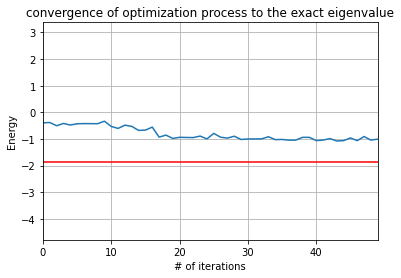

In [89]:
H2_approximated_energies = [-0.39382264141896883, -0.3822495929374258, -0.5033175529490026, -0.41735768179784205, -0.4764824622559096, -0.42979296952781826, -0.4228384932204727, -0.425224065316555, -0.4271084579074381, -0.332661414808598, -0.5300811848189961, -0.6031653592963949, -0.48153340394243654, -0.5277715371862204, -0.6787251719841828, -0.6677479680060077, -0.5543882481928336, -0.9310272531041798, -0.8556681028115487, -0.9793875714496547, -0.9376922355779178, -0.9443316020511052, -0.9479033199574993, -0.8922072962281791, -0.9977808166019475, -0.7909066497592354, -0.9349358264299427, -0.9666011625675006, -0.8967230002382112, -1.0189213021982153, -1.0005737207720709, -0.999298321405565, -0.9958476679895082, -0.9171376188476573, -1.0252614190107678, -1.018338251282066, -1.044397744326613, -1.0437300214312708, -0.9388947159502544, -0.9398813667422568, -1.0610480812721388, -1.042436035115538, -0.9860273517178535, -1.0752753892607296, -1.0633820368230062, -0.9616193853795404, -1.0640250395124078, -0.9088306493680886, -1.0433812516293983, -1.0054067217717302]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-1.8572750302023793, margin=5)

In [39]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:00, 16.39it/s]
15it [00:00, 17.81it/s]
15it [00:00, 18.12it/s]
15it [00:00, 17.98it/s]
15it [00:00, 18.21it/s]
15it [00:00, 16.87it/s]
15it [00:00, 18.43it/s]
15it [00:00, 17.59it/s]
15it [00:00, 16.92it/s]
15it [00:00, 16.03it/s]
15it [00:00, 17.70it/s]
15it [00:00, 18.06it/s]
15it [00:01, 15.00it/s]
15it [00:00, 18.13it/s]
15it [00:00, 18.43it/s]
15it [00:00, 16.86it/s]
15it [00:00, 17.07it/s]
15it [00:00, 16.12it/s]
15it [00:00, 17.38it/s]
15it [00:00, 18.41it/s]
15it [00:00, 17.49it/s]
15it [00:00, 18.17it/s]
15it [00:00, 18.52it/s]
15it [00:00, 18.42it/s]
15it [00:00, 16.14it/s]
15it [00:00, 18.13it/s]
15it [00:00, 17.89it/s]
15it [00:00, 17.53it/s]
15it [00:00, 17.52it/s]
15it [00:00, 15.81it/s]
15it [00:00, 17.96it/s]
15it [00:00, 18.07it/s]
15it [00:00, 18.47it/s]
15it [00:00, 15.74it/s]
15it [00:00, 17.59it/s]
15it [00:00, 18.10it/s]
15it [00:00, 15.98it/s]
15it [00:00, 17.07it/s]
15it [00:00, 17.21it/s]
15it [00:00, 16.28it/s]
15it [00:00, 17.90it/s]
15it [00:00, 18.

[ 6.58278077  3.31815922  4.01977161  6.35077861  3.83806423  2.3426144
  3.44254131  5.9975189   5.50299164  4.87969264  0.69839475  5.63233186
  3.01826563  0.18089534  2.34314683  3.97517512  3.79195376  1.68814698
  4.41174948  4.50782219  3.51093493  3.87680672  5.16646294  3.19181696
  2.08638313 -0.31223756  3.5479771   5.16532285  3.1508279   3.70664594
 -0.01652002  1.24513793]


15it [00:00, 16.53it/s]

CPU times: total: 42 s
Wall time: 44.4 s


In [40]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
Exact Eigenvalue:
(0.2142782384194731+0j)

Approximated Eigenvalue:
-1.4067861224128657

Approximation Error
5.565230948272628


In [ ]:
print(approximated_energies)
approximated_energies = []

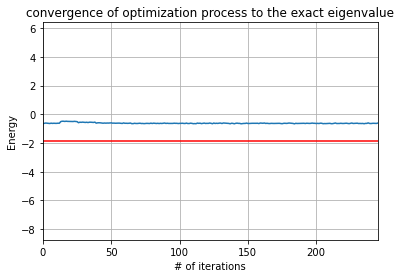

In [90]:
H2_approximated_energies = [-0.6479084750255486, -0.6276579569919597, -0.6079422008169065, -0.616731159779808, -0.6325842283091055, -0.6393897280901208, -0.6171807581727554, -0.632653791572579, -0.6213172282987715, -0.6295655663398093, -0.6289772030449229, -0.6186181091776035, -0.624022941533276, -0.5082839240612291, -0.48226570208794234, -0.4821361107003052, -0.4954020352078101, -0.4793435904590445, -0.49199670120300654, -0.49416478838441447, -0.502190052373643, -0.49599755978221166, -0.5020643548684793, -0.4889205213711024, -0.5018939914800866, -0.5099878400191491, -0.5856552068715944, -0.54923382599589, -0.5582306982767166, -0.5444314531693122, -0.5567710700669415, -0.5659113697818672, -0.552668511160273, -0.5735134318844516, -0.549852476753314, -0.5503189869962759, -0.5601864836520486, -0.5659896127460298, -0.5446950460298908, -0.615920984439197, -0.5928640404070656, -0.5879106801498322, -0.5935911543775607, -0.6075920247035514, -0.6201194518598445, -0.60623970115924, -0.6162790804378995, -0.6070899791213487, -0.6105620077787796, -0.604279338203177, -0.5953765787888684, -0.6176510100281449, -0.6121876903025966, -0.6221925707825862, -0.6167720694769763, -0.6138135616671906, -0.6141332165079305, -0.6280212409220817, -0.6360069982326235, -0.6007258601159454, -0.6251861183198779, -0.6230618384361196, -0.6294049945914133, -0.6233533946933156, -0.608497712991425, -0.6496414061454564, -0.6486467922145787, -0.6248046230879923, -0.6382435950247505, -0.6396933212611499, -0.6313975747684536, -0.6205882624714589, -0.6408121049037772, -0.6358325058878442, -0.6483418584555031, -0.6371649113759628, -0.6291839190391355, -0.6347573834032361, -0.6407098912056699, -0.6159176260854965, -0.6384554645835627, -0.6164080207309359, -0.625543079338974, -0.6382937503891668, -0.6264097132175528, -0.6420718561520969, -0.6267262725213436, -0.6374963711667498, -0.6193193504433864, -0.6078143278866533, -0.634472486357409, -0.6223512323012782, -0.6351163020561015, -0.634661177023637, -0.6327899211075433, -0.6336448686497769, -0.6193351633432258, -0.6281755978797693, -0.6264777231208046, -0.6414830476329384, -0.6307683399864691, -0.6307085701314388, -0.6206080402310008, -0.6348255969934301, -0.6396136598903551, -0.6119662685652434, -0.6416707355866279, -0.6413693107560723, -0.6177947197203094, -0.6298765228276698, -0.6523529064199631, -0.6449003109571184, -0.653383311719062, -0.6114270075961685, -0.6288547938898695, -0.618693644838608, -0.6474406100562011, -0.6311230491106903, -0.6116401562656182, -0.636431790506111, -0.6291838050229098, -0.6323232015973214, -0.6084567336875317, -0.6260410898582017, -0.6558980736383361, -0.6088478495140429, -0.6362772541154403, -0.6229687283270671, -0.6337477882049586, -0.6146890139542273, -0.6109822191193143, -0.6410668717503976, -0.6050360295204666, -0.6127109227117324, -0.613969481075047, -0.6330316470359499, -0.6336428860578563, -0.6579205656897767, -0.6226609914498723, -0.6308197002529959, -0.6592780043421462, -0.6286105470576249, -0.6142144474532307, -0.6308763800946607, -0.6313362339145869, -0.6587453552909762, -0.6439616021766039, -0.6342588475726809, -0.6348805630323535, -0.612208176680939, -0.6384209891698392, -0.6377259399102154, -0.6288355030414153, -0.6254287723561084, -0.6267028568621377, -0.633225553954038, -0.6266439989301029, -0.6219787315736918, -0.6444478946498267, -0.6078647889145464, -0.6169625336670495, -0.6228416937169068, -0.6055808453138738, -0.6349070986052844, -0.6233134657244299, -0.638807727216456, -0.6439324406558855, -0.6290682438485403, -0.6347278678305891, -0.6370807223116214, -0.6331202879928073, -0.6259391405710086, -0.6205239729014943, -0.6271330693467981, -0.6384914098927226, -0.6540996612097635, -0.6297277932870161, -0.6230026756130547, -0.6337458840743901, -0.6269616938156711, -0.6071713916280417, -0.6182364077263139, -0.6295847748388186, -0.6340000050667973, -0.662525648783056, -0.6268357485227919, -0.6383142008116837, -0.6356494637389134, -0.6334179386720562, -0.6368477711503842, -0.6258766827515051, -0.6250225216677815, -0.6402120922677865, -0.6215866553687236, -0.6300458164726813, -0.6349074242618946, -0.6281512038322912, -0.6106861518433435, -0.6257220729152266, -0.6264637065414248, -0.6413022282257185, -0.6287300650968061, -0.6415216331142828, -0.6177784438217981, -0.6235031629550336, -0.6522908854196745, -0.6433100700195024, -0.6467856500499529, -0.6383906423809346, -0.6353007399215785, -0.628267887248418, -0.6530534039557805, -0.6489154837903043, -0.6251303963665552, -0.606115215627397, -0.640564227336403, -0.6426262151446616, -0.6375465819155562, -0.6241657686495026, -0.6365874044036779, -0.6368987773426885, -0.6254336505997881, -0.6195698003196071, -0.6312797723656407, -0.6493745786523953, -0.6255032951930553, -0.6076271422511403, -0.6369485503847903, -0.633978893260772, -0.6247995690801257, -0.6181592078851024, -0.6413113581396256, -0.6357432503116383, -0.6413681655967249, -0.6349930744741815, -0.6553915345015394, -0.6333982709804692, -0.6323784240845362, -0.597462603561814, -0.6354799343741077, -0.6435513818689228, -0.6288306285283861, -0.6252986455639116, -0.6338258059332423, -0.6354797897494069, -0.6118871374772903]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-1.8572750302023793, margin=5)

##  Transverse Ising Model 4 qubits

In [42]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:00, 17.33it/s]
11it [00:00, 17.33it/s]
11it [00:00, 17.92it/s]
11it [00:00, 19.82it/s]
11it [00:00, 17.29it/s]
11it [00:00, 16.09it/s]
11it [00:00, 17.89it/s]
11it [00:00, 16.99it/s]
11it [00:00, 17.44it/s]
11it [00:00, 15.69it/s]
11it [00:00, 18.90it/s]
11it [00:00, 17.46it/s]
11it [00:00, 17.76it/s]
11it [00:00, 17.76it/s]
11it [00:00, 18.92it/s]
11it [00:00, 20.05it/s]
11it [00:00, 17.17it/s]
11it [00:00, 17.92it/s]
11it [00:00, 16.95it/s]
11it [00:00, 17.04it/s]
11it [00:00, 17.54it/s]
11it [00:00, 17.49it/s]
11it [00:00, 18.36it/s]
11it [00:00, 16.20it/s]
11it [00:00, 18.83it/s]
11it [00:00, 18.69it/s]
11it [00:00, 18.96it/s]
11it [00:00, 16.96it/s]
11it [00:00, 16.04it/s]
11it [00:00, 16.39it/s]
11it [00:00, 16.26it/s]
11it [00:00, 15.14it/s]
11it [00:00, 16.53it/s]
11it [00:00, 18.81it/s]
11it [00:00, 17.07it/s]
11it [00:00, 18.11it/s]
11it [00:00, 17.30it/s]
11it [00:00, 18.80it/s]
11it [00:00, 17.49it/s]
11it [00:00, 17.96it/s]
11it [00:00, 17.95it/s]
11it [00:00, 15.

[1.7175271  4.04914999 4.63972999 4.10855598 3.56867925 6.33866085
 3.25295661 1.65332394 6.39810188 4.19831472 2.69670148 1.880621
 3.19809434 6.14222693 3.89941784 5.65360729 2.612273   4.30917659
 0.15786842 4.03217511 4.27317171 1.28831896 6.15964565 5.8670926
 2.45173203 6.86213063 1.96430629 3.37646442 2.74816057 0.72898792
 4.75991673 3.75942777]


11it [00:00, 18.06it/s]

CPU times: total: 30.8 s
Wall time: 32.4 s


In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

[(2.3867070442313216+0j), (2.3718326043433704+0j), (1.6958488386667439+0j), (1.6816520928402046+0j), (0.3444947223438019+0j), (0.2757654176709828+0j), (0.20992649961322052+0j), (0.14239915569453057+0j), (-0.2505930484227001+0j), (-0.31907768442618767+0j), (-0.47710503946487287+0j), (-0.5462047134056278+0j), (-1.7583827504312988+0j), (-1.8497137109270194+0j), (-1.9080638482930956+0j), (-1.9994855800333675+0j)]
Exact Eigenvalue:
(2.3867070442313216+0j)

Approximated Eigenvalue:
1.1547201648746055

Approximation Error
0.516186887005857


In [45]:
print(approximated_energies)
approximated_energies = []

[-0.6777058557291457, -0.6983359724764865, -0.5783177681466453, -0.7310494222413595, -0.7501075420770531, -0.7714764310008229, -0.645309887248009, -0.7602290312658398, -0.685839146130563, -0.6249531155539204, -0.7172062091380498, -0.7260091906503874, -0.7524934406487322, -0.8122444636014666, -0.7827788970644554, -0.8785894915285293, -0.8783026075982026, -0.8681957841396474, -0.6979535200956545, -0.7970730827587923, -0.8375953931364963, -0.8680908507388703, -0.8550856598969494, -0.7494582523597499, -0.9319864493879706, -1.050695471293816, -0.9718652613821812, -0.9976294913629388, -0.9819990122638518, -1.0777786545813604, -1.0789406179219962, -1.0489272956618043, -1.0897075322323753, -1.1383743699515112, -0.858395316193702, -1.1854124931272356, -1.2182988464461781, -1.256025885999571, -1.302304362663645, -1.3477697730300497, -1.3378631274965045, -1.2677744333479488, -1.4198367004049475, -1.3958599575970339, -1.3390496992721794, -1.3836480316056332, -1.3735039872988717, -1.347833701029244

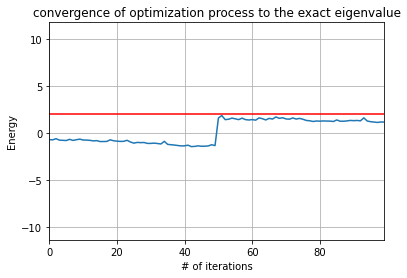

In [91]:
TI_approximated_energies = [-0.6777058557291457, -0.6983359724764865, -0.5783177681466453, -0.7310494222413595, -0.7501075420770531, -0.7714764310008229, -0.645309887248009, -0.7602290312658398, -0.685839146130563, -0.6249531155539204, -0.7172062091380498, -0.7260091906503874, -0.7524934406487322, -0.8122444636014666, -0.7827788970644554, -0.8785894915285293, -0.8783026075982026, -0.8681957841396474, -0.6979535200956545, -0.7970730827587923, -0.8375953931364963, -0.8680908507388703, -0.8550856598969494, -0.7494582523597499, -0.9319864493879706, -1.050695471293816, -0.9718652613821812, -0.9976294913629388, -0.9819990122638518, -1.0777786545813604, -1.0789406179219962, -1.0489272956618043, -1.0897075322323753, -1.1383743699515112, -0.858395316193702, -1.1854124931272356, -1.2182988464461781, -1.256025885999571, -1.302304362663645, -1.3477697730300497, -1.3378631274965045, -1.2677744333479488, -1.4198367004049475, -1.3958599575970339, -1.3390496992721794, -1.3836480316056332, -1.3735039872988717, -1.347833701029244, -1.2209779532561293, -1.3108689117281935, 1.6230259124259234, 1.8860073756981175, 1.4507699018218545, 1.4933963747370718, 1.6142693841263356, 1.5367472009946639, 1.4531036862227245, 1.6117112465030614, 1.4523776905490806, 1.4119600311217209, 1.4560527768212879, 1.3934352880969003, 1.6347505602806014, 1.5527489876701368, 1.416166837370458, 1.58438888817331, 1.511498216299983, 1.7380579067364228, 1.5913793827423008, 1.649901391109723, 1.5256141768167153, 1.4989322139132617, 1.6328488658778453, 1.5103517623133074, 1.5834247569068824, 1.489833782368439, 1.3634641509912584, 1.3289890255521495, 1.2545871425856316, 1.3066980706390445, 1.2876537588660852, 1.312063576231166, 1.30025151417196, 1.2936945708202074, 1.254340348762971, 1.4174562566621232, 1.2808272098154885, 1.2815603677093323, 1.3145714877667953, 1.364844153563909, 1.3433131571270016, 1.3619927255425877, 1.3248069564826843, 1.6406666171413353, 1.3041745971819836, 1.232165954854988, 1.1946873442683028, 1.151226205156569, 1.200528493209084, 1.1950345104685873]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=1.9994855800333675, margin=3)

In [47]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:00, 17.12it/s]
11it [00:00, 17.66it/s]
11it [00:00, 15.92it/s]
11it [00:00, 16.47it/s]
11it [00:00, 17.64it/s]
11it [00:00, 17.64it/s]
11it [00:00, 17.20it/s]
11it [00:00, 18.50it/s]
11it [00:00, 15.58it/s]
11it [00:00, 14.21it/s]
11it [00:00, 13.90it/s]
11it [00:00, 17.77it/s]
11it [00:00, 18.32it/s]
11it [00:00, 17.68it/s]
11it [00:00, 16.44it/s]
11it [00:00, 16.15it/s]
11it [00:00, 19.77it/s]
11it [00:00, 18.44it/s]
11it [00:00, 17.60it/s]
11it [00:00, 17.50it/s]
11it [00:00, 17.29it/s]
11it [00:00, 17.23it/s]
11it [00:00, 17.95it/s]
11it [00:00, 16.92it/s]
11it [00:00, 17.22it/s]
11it [00:00, 16.51it/s]
11it [00:00, 17.35it/s]
11it [00:00, 17.71it/s]
11it [00:00, 17.65it/s]
11it [00:00, 18.16it/s]
11it [00:00, 16.42it/s]
11it [00:00, 16.74it/s]
11it [00:00, 16.29it/s]
11it [00:00, 18.77it/s]
11it [00:00, 19.80it/s]
11it [00:00, 17.51it/s]
11it [00:00, 12.44it/s]
11it [00:00, 16.78it/s]
11it [00:00, 18.38it/s]
11it [00:00, 19.74it/s]
11it [00:00, 16.54it/s]
11it [00:00, 17.

[6.29079134 2.93243172 7.07235296 1.0901409  4.48215655 2.44914309
 6.10052701 1.25513762 2.69876654 2.94832904 2.39348003 4.39653725
 1.94473031 1.05779772 3.73952816 2.03680623 4.69764294 3.95359949
 0.51684782 4.68196301 3.02515857 5.06820058 1.07904976 2.90388894
 5.20505425 3.27813573 6.10177065 2.6819823  4.73550906 1.23858598
 1.6619556  1.88543901]


11it [00:00, 17.76it/s]

CPU times: total: 31.5 s
Wall time: 32.9 s


In [48]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

[(2.3867070442313216+0j), (2.3718326043433704+0j), (1.6958488386667439+0j), (1.6816520928402046+0j), (0.3444947223438019+0j), (0.2757654176709828+0j), (0.20992649961322052+0j), (0.14239915569453057+0j), (-0.2505930484227001+0j), (-0.31907768442618767+0j), (-0.47710503946487287+0j), (-0.5462047134056278+0j), (-1.7583827504312988+0j), (-1.8497137109270194+0j), (-1.9080638482930956+0j), (-1.9994855800333675+0j)]
Exact Eigenvalue:
(2.3867070442313216+0j)

Approximated Eigenvalue:
1.4022855584856302

Approximation Error
0.4124601249763942


In [49]:
print(approximated_energies)
approximated_energies = []

[2.1005725170623246, 1.8026868259942177, 1.9856843533617485, 1.7816441840034218, 1.7135091291527884, 1.7075016766702995, 1.7437216275461889, 1.6342305416589855, 1.806749922475489, 1.746307685846126, 1.5568141274663594, 1.6150739634121074, 1.3939151939524814, 1.3590820452640606, 1.3827284000769706, 1.4028119036623405, 1.4882043604895492, 1.5501752561493995, 1.4518470101664436, 1.5665803906683744, 1.4836084124688318, 1.5358075028690947, 1.4030832033049836, 1.3963891061464542, 1.5516640739115208, 1.5540466491817604, 1.4363467486170503, 1.4668144929464553, 1.4015860930938602, 1.4041158860682534, 1.3791905920465461, 1.3641994119082812, 1.43100908296807, 1.6071557496858118, 1.458552076599119, 1.4541718456964803, 1.3627959918603407, 1.5590495283187351, 1.413709824641411, 1.5502759261135257, 1.4212608265901974, 1.5566966370556912, 1.4090092158599477, 1.3987644799912267, 1.4422631934639845, 1.3775355318189964, 1.448037363279123, 1.429296147675628, 1.4373876256960842, 1.37268332484334]


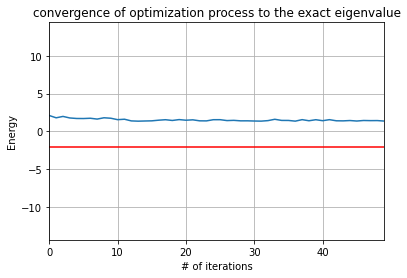

In [93]:
TI_approximated_energies = [2.1005725170623246, 1.8026868259942177, 1.9856843533617485, 1.7816441840034218, 1.7135091291527884, 1.7075016766702995, 1.7437216275461889, 1.6342305416589855, 1.806749922475489, 1.746307685846126, 1.5568141274663594, 1.6150739634121074, 1.3939151939524814, 1.3590820452640606, 1.3827284000769706, 1.4028119036623405, 1.4882043604895492, 1.5501752561493995, 1.4518470101664436, 1.5665803906683744, 1.4836084124688318, 1.5358075028690947, 1.4030832033049836, 1.3963891061464542, 1.5516640739115208, 1.5540466491817604, 1.4363467486170503, 1.4668144929464553, 1.4015860930938602, 1.4041158860682534, 1.3791905920465461, 1.3641994119082812, 1.43100908296807, 1.6071557496858118, 1.458552076599119, 1.4541718456964803, 1.3627959918603407, 1.5590495283187351, 1.413709824641411, 1.5502759261135257, 1.4212608265901974, 1.5566966370556912, 1.4090092158599477, 1.3987644799912267, 1.4422631934639845, 1.3775355318189964, 1.448037363279123, 1.429296147675628, 1.4373876256960842, 1.37268332484334]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.9994855800333675, margin=3)

##  Transverse Ising Model 3 qubits

In [51]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [52]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

In [53]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00, 20.52it/s]
7it [00:00, 26.81it/s]
7it [00:00, 21.44it/s]
7it [00:00, 23.89it/s]
7it [00:00, 25.78it/s]
7it [00:00, 20.24it/s]
7it [00:00, 25.93it/s]
7it [00:00, 23.12it/s]
7it [00:00, 24.11it/s]
7it [00:00, 26.43it/s]
7it [00:00, 18.52it/s]
7it [00:00, 23.09it/s]
7it [00:00, 24.01it/s]
7it [00:00, 28.61it/s]
7it [00:00, 13.56it/s]
7it [00:00, 26.26it/s]
7it [00:00, 20.64it/s]
7it [00:00, 28.17it/s]
7it [00:00, 20.27it/s]
7it [00:00, 13.59it/s]
7it [00:00, 16.97it/s]
7it [00:00, 18.50it/s]
7it [00:00, 23.20it/s]
7it [00:00, 16.73it/s]
7it [00:00, 24.70it/s]
7it [00:00, 19.29it/s]
7it [00:00, 25.94it/s]
7it [00:00, 18.21it/s]
7it [00:00, 24.46it/s]
7it [00:00, 21.62it/s]
7it [00:00, 22.85it/s]
7it [00:00, 27.09it/s]
7it [00:00, 19.77it/s]
7it [00:00, 26.89it/s]
7it [00:00, 18.82it/s]
7it [00:00, 26.18it/s]
7it [00:00, 20.29it/s]
7it [00:00, 22.34it/s]
7it [00:00, 19.84it/s]
7it [00:00, 24.41it/s]
7it [00:00, 18.32it/s]
7it [00:00, 26.85it/s]
7it [00:00, 21.32it/s]
7it [00:00,

[5.71833036 0.79408029 5.52244815 3.39155307 2.5207238  5.87135594
 1.40040336 0.54281723 4.43520118 3.78782329 0.62356183 3.18731537
 0.55488831 1.5370349  4.57859572 2.67564693 5.64372384 2.47513751
 2.31899237 5.58875951 3.33004281 4.6220426  1.8485522  5.53243562]


7it [00:00, 26.99it/s]

CPU times: total: 15.5 s
Wall time: 16.6 s


In [54]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

[(1.4283924798262082+0j), (1.4216636087077101+0j), (0.5543478038595204+0j), (0.5479228225821259+0j), (-0.8433012058342556+0j), (-0.8673630797839832+0j), (-1.1089522226243493+0j), (-1.1327102067329746+0j)]
Exact Eigenvalue:
(1.4283924798262082+0j)

Approximated Eigenvalue:
0.4875821683798852

Approximation Error
0.6586497231914795


In [55]:
print(approximated_energies)
approximated_energies = []

[1.0665526939581906, 0.8420622296596334, 1.0197771122594583, 0.6877242236878522, 0.7307272857007618, 0.8192680220956302, 0.6928774936835811, 0.7575106154307754, 0.8440527795402201, 0.6166958541076396, 0.5962611398999803, 0.6724867153985509, 0.5982267225797555, 0.6218309929803445, 0.7347817803336331, 0.6640554100761208, 0.6793343176600954, 0.5236720942217327, 0.6148481902691109, 0.6526693160832819, 0.7960125950866443, 0.5656092827319117, 0.5522285596311993, 0.5564397840163393, 0.5661787182816588, 0.6190130918729995, 0.6006654459539995, 0.6272511798405095, 0.6326821923351869, 0.5353936726739561, 0.5635066989869353, 0.5424664381580224, 0.5964946095425995, 0.545939330012499, 0.5767751886232704, 0.5586917543526694, 0.5546203083845577, 0.5843664631518772, 0.5463069596970092, 0.5561523731230638, 0.6145309850195058, 0.5806286924420995, 0.504429927566314, 0.4899628833132054, 0.5446022489022702, 0.4856434634458589, 0.46667379756662736, 0.4834282713879381, 0.5014047277577516, 0.44235613595833845]

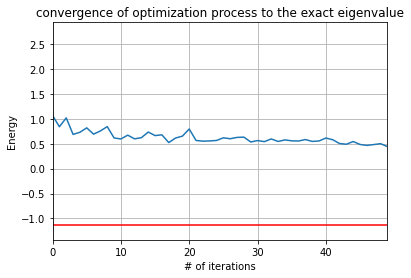

In [94]:
TI_approximated_energies = [1.0665526939581906, 0.8420622296596334, 1.0197771122594583, 0.6877242236878522, 0.7307272857007618, 0.8192680220956302, 0.6928774936835811, 0.7575106154307754, 0.8440527795402201, 0.6166958541076396, 0.5962611398999803, 0.6724867153985509, 0.5982267225797555, 0.6218309929803445, 0.7347817803336331, 0.6640554100761208, 0.6793343176600954, 0.5236720942217327, 0.6148481902691109, 0.6526693160832819, 0.7960125950866443, 0.5656092827319117, 0.5522285596311993, 0.5564397840163393, 0.5661787182816588, 0.6190130918729995, 0.6006654459539995, 0.6272511798405095, 0.6326821923351869, 0.5353936726739561, 0.5635066989869353, 0.5424664381580224, 0.5964946095425995, 0.545939330012499, 0.5767751886232704, 0.5586917543526694, 0.5546203083845577, 0.5843664631518772, 0.5463069596970092, 0.5561523731230638, 0.6145309850195058, 0.5806286924420995, 0.504429927566314, 0.4899628833132054, 0.5446022489022702, 0.4856434634458589, 0.46667379756662736, 0.4834282713879381, 0.5014047277577516, 0.44235613595833845]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.1327102067329746, margin=3)

In [57]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 18.40it/s]
7it [00:00, 26.23it/s]
7it [00:00, 19.75it/s]
7it [00:00, 26.07it/s]
7it [00:00, 20.42it/s]
7it [00:00, 25.90it/s]
7it [00:00, 20.97it/s]
7it [00:00, 23.78it/s]
7it [00:00, 27.12it/s]
7it [00:00, 17.00it/s]
7it [00:00, 19.19it/s]
7it [00:00, 18.73it/s]
7it [00:00, 18.72it/s]
7it [00:00, 25.28it/s]
7it [00:00, 28.88it/s]
7it [00:00, 19.95it/s]
7it [00:00, 25.31it/s]
7it [00:00, 18.73it/s]
7it [00:00, 27.81it/s]
7it [00:00, 19.14it/s]
7it [00:00, 26.20it/s]
7it [00:00, 19.66it/s]
7it [00:00, 26.40it/s]
7it [00:00, 20.28it/s]
7it [00:00, 25.25it/s]
7it [00:00, 19.34it/s]
7it [00:00, 26.78it/s]
7it [00:00, 21.01it/s]
7it [00:00, 20.34it/s]
7it [00:00, 22.29it/s]
7it [00:00, 22.77it/s]
7it [00:00, 27.34it/s]
7it [00:00, 18.22it/s]
7it [00:00, 25.81it/s]
7it [00:00, 18.54it/s]
7it [00:00, 26.00it/s]
7it [00:00, 21.86it/s]
7it [00:00, 23.04it/s]
7it [00:00, 26.70it/s]
7it [00:00, 20.36it/s]
7it [00:00, 24.70it/s]
7it [00:00, 24.09it/s]
7it [00:00, 19.79it/s]
7it [00:00,

[1.78681642 0.09470285 0.21335566 3.38656256 2.3174256  3.99528522
 2.38186067 4.37880169 6.4570121  2.46969558 3.86743796 2.51685957
 0.40835227 3.74674776 2.68129575 5.02271801 0.12639482 1.48159197
 2.38389724 2.74735206 3.36822785 4.08889197 2.88654165 0.6336175 ]


7it [00:00, 18.46it/s]

CPU times: total: 15.5 s
Wall time: 16.4 s


In [58]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

[(1.4283924798262082+0j), (1.4216636087077101+0j), (0.5543478038595204+0j), (0.5479228225821259+0j), (-0.8433012058342556+0j), (-0.8673630797839832+0j), (-1.1089522226243493+0j), (-1.1327102067329746+0j)]
Exact Eigenvalue:
(1.4283924798262082+0j)

Approximated Eigenvalue:
0.34126808807108977

Approximation Error
0.7610824105482467


In [59]:
print(approximated_energies)
approximated_energies = []

[0.6978303611546509, 0.9239044048650721, 0.7202180007801554, 0.7841975110467574, 0.7056564072013365, 0.6645135011522841, 0.6551214996123991, 0.5627861552690736, 0.6950182299606796, 0.559697777553848, 0.5275744797549038, 0.5488634161533403, 0.6056347196410834, 0.6639771739656131, 0.6446430153562294, 0.6330586699863082, 0.5672135556513708, 0.6773021381503115, 0.713732418655986, 0.6444044861772957, 0.5299481351788735, 0.7420994929344648, 0.535359059505184, 0.5376004190530258, 0.550727892068356, 0.3434386306203051, 0.5486422357058132, 0.4042952549195083, 0.45238281126890406, 0.44059114324495874, 0.675947729052466, 0.36172629388196104, 0.44210083249655313, 0.36131209543703796, 0.35257096581955333, 0.43332110681406977, 0.3770149076538985, 0.45047483975511865, 0.39201703230416285, 0.3612492597193645, 0.39204909680796013, 0.3798153379421609, 0.3340276689441415, 0.35201351852102425, 0.33255403912959014, 0.3543370161118083, 0.3715462500739221, 0.3460953047293705, 0.3412731905350974, 0.3970513481

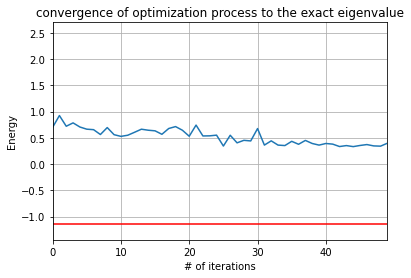

In [95]:
TI_approximated_energies = [0.6978303611546509, 0.9239044048650721, 0.7202180007801554, 0.7841975110467574, 0.7056564072013365, 0.6645135011522841, 0.6551214996123991, 0.5627861552690736, 0.6950182299606796, 0.559697777553848, 0.5275744797549038, 0.5488634161533403, 0.6056347196410834, 0.6639771739656131, 0.6446430153562294, 0.6330586699863082, 0.5672135556513708, 0.6773021381503115, 0.713732418655986, 0.6444044861772957, 0.5299481351788735, 0.7420994929344648, 0.535359059505184, 0.5376004190530258, 0.550727892068356, 0.3434386306203051, 0.5486422357058132, 0.4042952549195083, 0.45238281126890406, 0.44059114324495874, 0.675947729052466, 0.36172629388196104, 0.44210083249655313, 0.36131209543703796, 0.35257096581955333, 0.43332110681406977, 0.3770149076538985, 0.45047483975511865, 0.39201703230416285, 0.3612492597193645, 0.39204909680796013, 0.3798153379421609, 0.3340276689441415, 0.35201351852102425, 0.33255403912959014, 0.3543370161118083, 0.3715462500739221, 0.3460953047293705, 0.3412731905350974, 0.3970513481849052]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.1327102067329746, margin=3)

##  Transverse Ising Model 2 qubits

In [61]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [62]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [63]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 35.16it/s]
3it [00:00, 17.60it/s]
3it [00:00, 33.95it/s]
3it [00:00, 36.20it/s]
3it [00:00, 39.87it/s]
3it [00:00, 31.23it/s]
3it [00:00, 33.33it/s]
3it [00:00, 21.26it/s]
3it [00:00, 34.25it/s]
3it [00:00, 29.06it/s]
3it [00:00, 39.55it/s]
3it [00:00, 41.16it/s]
3it [00:00, 41.44it/s]
3it [00:00, 38.98it/s]
3it [00:00, 41.11it/s]
3it [00:00, 26.30it/s]
3it [00:00, 24.18it/s]
3it [00:00, 35.28it/s]
3it [00:00, 37.33it/s]
3it [00:00, 36.17it/s]
3it [00:00, 37.21it/s]
3it [00:00, 39.35it/s]
3it [00:00, 19.42it/s]
3it [00:00, 24.89it/s]
3it [00:00, 27.32it/s]
3it [00:00, 26.66it/s]
3it [00:00, 29.64it/s]
3it [00:00, 19.46it/s]
3it [00:00, 20.55it/s]
3it [00:00, 29.10it/s]
3it [00:00, 36.27it/s]
3it [00:00, 36.19it/s]
3it [00:00, 37.20it/s]
3it [00:00, 39.72it/s]
3it [00:00, 21.84it/s]
3it [00:00, 31.84it/s]
3it [00:00, 38.47it/s]
3it [00:00, 40.25it/s]
3it [00:00, 27.73it/s]
3it [00:00, 38.59it/s]
3it [00:00, 35.63it/s]
3it [00:00, 39.78it/s]
3it [00:00, 21.08it/s]
3it [00:00,

[4.18408015 4.50127657 4.97527972 5.89424184 2.34540161 2.83757644
 4.62127455 6.228047   6.69788366 4.61733161 1.90405917 4.73191731
 3.3733281  0.39435586 3.71651082 1.67615817]


3it [00:00, 28.13it/s]

CPU times: total: 4.94 s
Wall time: 5.23 s


In [64]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

[(1.0269745088446243+0j), (0.9035465241407012+0j), (-0.9035465241407018+0j), (-1.0269745088446245+0j)]
Exact Eigenvalue:
(1.0269745088446243+0j)

Approximated Eigenvalue:
-0.2699043655237947

Approximation Error
0.7371849415936869


In [65]:
print(approximated_energies)
approximated_energies = []

[0.19871788606374985, 0.5389276345472341, 0.10866236440635696, 0.008600673675920434, 0.11533314378838605, 0.12533931286142969, 0.05362843450461685, 0.29377649225766456, -0.13648877788321256, -0.24322124799567824, -0.001405495397123313, -0.2265442995406055, -0.1381564727287199, 0.29377649225766456, 0.31712422009476643, -0.23488277376814193, -0.2332150789226346, -0.043097866534805185, -0.2048642665490109, -0.10146718612755978, -0.24989202737770733, -0.17151036963886546, -0.24655663768669278, -0.2715720603693019, -0.26490128098727284, -0.19485809747596727, -0.27490745006031647, -0.1681749799478508, -0.23655046861364915, -0.20152887685799636, -0.278242839751331, -0.2699043655237947, -0.2548951119142292, -0.25155972222321465, -0.2715720603693019, -0.20653196139451824, -0.27323975521480925, -0.2048642665490109, -0.27323975521480925, -0.22487660469509818, -0.2482243325322001, -0.2715720603693019, -0.26656897583278016, -0.2548951119142292, -0.26656897583278016, -0.2632335861417656, -0.27157206

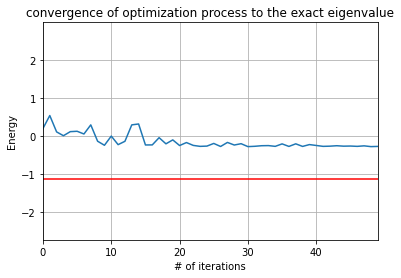

In [96]:
TI_approximated_energies = [0.19871788606374985, 0.5389276345472341, 0.10866236440635696, 0.008600673675920434, 0.11533314378838605, 0.12533931286142969, 0.05362843450461685, 0.29377649225766456, -0.13648877788321256, -0.24322124799567824, -0.001405495397123313, -0.2265442995406055, -0.1381564727287199, 0.29377649225766456, 0.31712422009476643, -0.23488277376814193, -0.2332150789226346, -0.043097866534805185, -0.2048642665490109, -0.10146718612755978, -0.24989202737770733, -0.17151036963886546, -0.24655663768669278, -0.2715720603693019, -0.26490128098727284, -0.19485809747596727, -0.27490745006031647, -0.1681749799478508, -0.23655046861364915, -0.20152887685799636, -0.278242839751331, -0.2699043655237947, -0.2548951119142292, -0.25155972222321465, -0.2715720603693019, -0.20653196139451824, -0.27323975521480925, -0.2048642665490109, -0.27323975521480925, -0.22487660469509818, -0.2482243325322001, -0.2715720603693019, -0.26656897583278016, -0.2548951119142292, -0.26656897583278016, -0.2632335861417656, -0.2715720603693019, -0.25823050160524375, -0.278242839751331, -0.27323975521480925]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.1327102067329746, margin=3)

In [67]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 34.83it/s]
3it [00:00, 35.92it/s]
3it [00:00, 36.99it/s]
3it [00:00, 38.63it/s]
3it [00:00, 38.68it/s]
3it [00:00, 20.34it/s]
3it [00:00, 33.54it/s]
3it [00:00, 33.92it/s]
3it [00:00, 37.33it/s]
3it [00:00, 37.97it/s]
3it [00:00, 28.03it/s]
3it [00:00, 35.51it/s]
3it [00:00, 40.10it/s]
3it [00:00, 37.18it/s]
3it [00:00, 37.36it/s]
3it [00:00, 38.61it/s]
3it [00:00, 22.70it/s]
3it [00:00, 27.65it/s]
3it [00:00, 32.91it/s]
3it [00:00, 37.13it/s]
3it [00:00, 34.50it/s]
3it [00:00, 37.34it/s]
3it [00:00, 38.85it/s]
3it [00:00, 16.52it/s]
3it [00:00, 33.48it/s]
3it [00:00, 38.37it/s]
3it [00:00, 37.34it/s]
3it [00:00, 36.31it/s]
3it [00:00, 38.26it/s]
3it [00:00, 31.27it/s]
3it [00:00, 19.77it/s]
3it [00:00, 34.70it/s]
3it [00:00, 38.35it/s]
3it [00:00, 35.48it/s]
3it [00:00, 37.90it/s]
3it [00:00, 37.26it/s]
3it [00:00, 18.85it/s]
3it [00:00, 27.12it/s]
3it [00:00, 35.40it/s]
3it [00:00, 30.84it/s]
3it [00:00, 34.91it/s]
3it [00:00, 35.90it/s]
3it [00:00, 36.97it/s]
3it [00:00,

[ 5.6237225  -0.25270364  1.30384468  2.78196217  2.6885643   4.77877224
  3.37561148  3.36353724  4.575097    4.3568692   3.73110623  5.23308905
  0.74021255  2.00298602  5.49706642  1.51109745]


3it [00:00, 16.98it/s]

CPU times: total: 4.8 s
Wall time: 5.02 s


In [68]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

[(1.0269745088446243+0j), (0.9035465241407012+0j), (-0.9035465241407018+0j), (-1.0269745088446245+0j)]
Exact Eigenvalue:
(1.0269745088446243+0j)

Approximated Eigenvalue:
-0.27323975521480925

Approximation Error
0.7339371592365892


In [69]:
print(approximated_energies)
approximated_energies = []

[1.1493039480028973, 0.9791990737611549, 0.9808667686066622, 0.9375067026234731, 0.8858081624127475, 0.5956292592944815, 0.036951486049544124, -0.11147335520060342, -0.2048642665490109, -0.0064085799336450755, -0.14315955726524177, 0.07030538295968958, -0.023085528388717802, -0.03142400261625422, 0.07530846749621145, -0.21153504593104, -0.19152270778495273, 0.37215814999650654, -0.043097866534805185, -0.07645176344495064, -0.21320274077654733, -0.12648260881016893, -0.14983033664727086, -0.03976247684379064, 0.08531463656925509, -0.1398241675742271, -0.16650728510234358, -0.16984267479335813, -0.12815030365567626, -0.1464949469562563, -0.19485809747596727, -0.24155355315017102, -0.2699043655237947, -0.22320890984959096, -0.2765751449058238, -0.21320274077654733, -0.2682366706782874, -0.26490128098727284, -0.2699043655237947, -0.04143017168929786, -0.2699043655237947, -0.2615658912962583, -0.2598981964507511, -0.26656897583278016, -0.27323975521480925, -0.2715720603693019, -0.2699043655

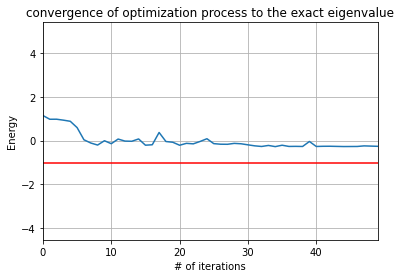

In [97]:
TI_approximated_energies = [1.1493039480028973, 0.9791990737611549, 0.9808667686066622, 0.9375067026234731, 0.8858081624127475, 0.5956292592944815, 0.036951486049544124, -0.11147335520060342, -0.2048642665490109, -0.0064085799336450755, -0.14315955726524177, 0.07030538295968958, -0.023085528388717802, -0.03142400261625422, 0.07530846749621145, -0.21153504593104, -0.19152270778495273, 0.37215814999650654, -0.043097866534805185, -0.07645176344495064, -0.21320274077654733, -0.12648260881016893, -0.14983033664727086, -0.03976247684379064, 0.08531463656925509, -0.1398241675742271, -0.16650728510234358, -0.16984267479335813, -0.12815030365567626, -0.1464949469562563, -0.19485809747596727, -0.24155355315017102, -0.2699043655237947, -0.22320890984959096, -0.2765751449058238, -0.21320274077654733, -0.2682366706782874, -0.26490128098727284, -0.2699043655237947, -0.04143017168929786, -0.2699043655237947, -0.2615658912962583, -0.2598981964507511, -0.26656897583278016, -0.27323975521480925, -0.2715720603693019, -0.2699043655237947, -0.24322124799567824, -0.25322741706872187, -0.2632335861417656]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.0269745088446245, margin=3)

## H2 Molecule 2 qubits

In [71]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

In [72]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 34.66it/s]
4it [00:00, 35.91it/s]
4it [00:00, 38.47it/s]
4it [00:00, 25.54it/s]
4it [00:00, 29.84it/s]
4it [00:00, 27.61it/s]
4it [00:00, 36.34it/s]
4it [00:00, 36.74it/s]
4it [00:00, 36.54it/s]
4it [00:00, 25.98it/s]
4it [00:00, 29.59it/s]
4it [00:00, 36.85it/s]
4it [00:00, 34.11it/s]
4it [00:00, 34.00it/s]
4it [00:00, 20.45it/s]
4it [00:00, 33.28it/s]
4it [00:00, 39.09it/s]
4it [00:00, 41.65it/s]
4it [00:00, 33.24it/s]
4it [00:00, 20.69it/s]
4it [00:00, 27.29it/s]
4it [00:00, 24.64it/s]
4it [00:00, 33.38it/s]
4it [00:00, 38.51it/s]
4it [00:00, 25.16it/s]
4it [00:00, 28.47it/s]
4it [00:00, 29.94it/s]
4it [00:00, 38.24it/s]
4it [00:00, 37.44it/s]
4it [00:00, 37.79it/s]
4it [00:00, 20.80it/s]
4it [00:00, 35.75it/s]
4it [00:00, 36.12it/s]
4it [00:00, 34.06it/s]
4it [00:00, 38.02it/s]
4it [00:00, 23.76it/s]
4it [00:00, 30.50it/s]
4it [00:00, 29.92it/s]
4it [00:00, 32.59it/s]
4it [00:00, 36.25it/s]
4it [00:00, 23.17it/s]
4it [00:00, 26.96it/s]
4it [00:00, 39.18it/s]
4it [00:00,

[0.48036058 1.04208512 5.93448814 0.39627953 4.89837763 2.04402748
 2.8721164  2.34879568 2.69200452 3.86546053 2.98221668 3.33499344
 4.59831565 2.56900593 3.24381002 2.16314762]


4it [00:00, 28.30it/s]

CPU times: total: 6.48 s
Wall time: 6.78 s


In [73]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

[(0.30584559711037274+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (-1.0051067048832336+0j)]
Exact Eigenvalue:
(0.30584559711037274+0j)

Approximated Eigenvalue:
-0.9968652166637522

Approximation Error
2.2593740962175963


In [74]:
print(approximated_energies)
approximated_energies = []

[-0.7356817829656852, -0.4605290367655781, -0.7908280853763583, -0.8609846358821742, -0.8349318931943618, -0.7521807269955327, -0.9276366414204558, -0.7991491889513118, -0.8905260301462867, -0.7314096806409685, -0.6782005023034486, -0.9793260048376484, -0.9175548734682202, -0.8488381515290114, -0.9272205936616732, -0.9844789216487289, -0.9826385677163252, -0.821857656177628, -0.9159065016246741, -0.6627899514414584, -0.9836787613129315, -0.9715806249303188, -0.949816619954954, -0.9822225199575425, -0.9909921258705944, -0.9910401770425459, -0.8686024976613795, -0.9928324798029978, -0.9682519460614587, -0.980334189052837, -0.9483284434177965, -0.9698523409327027, -0.9031525068214182, -0.9923683808722636, -0.9589224356723679, -0.9976653027998996, -0.9704603707803431, -0.9854391288916153, -0.9425835385496095, -0.9982414716654212, -1.001009949259644, -0.9695003861364053, -1.0064028993315337, -0.9826866930879263, -0.9975853164461796, -0.9948488482333749, -1.002114161619086, -0.99848150492623

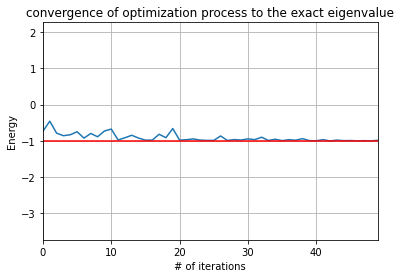

In [98]:
H2_approximated_energies = [-0.7356817829656852, -0.4605290367655781, -0.7908280853763583, -0.8609846358821742, -0.8349318931943618, -0.7521807269955327, -0.9276366414204558, -0.7991491889513118, -0.8905260301462867, -0.7314096806409685, -0.6782005023034486, -0.9793260048376484, -0.9175548734682202, -0.8488381515290114, -0.9272205936616732, -0.9844789216487289, -0.9826385677163252, -0.821857656177628, -0.9159065016246741, -0.6627899514414584, -0.9836787613129315, -0.9715806249303188, -0.949816619954954, -0.9822225199575425, -0.9909921258705944, -0.9910401770425459, -0.8686024976613795, -0.9928324798029978, -0.9682519460614587, -0.980334189052837, -0.9483284434177965, -0.9698523409327027, -0.9031525068214182, -0.9923683808722636, -0.9589224356723679, -0.9976653027998996, -0.9704603707803431, -0.9854391288916153, -0.9425835385496095, -0.9982414716654212, -1.001009949259644, -0.9695003861364053, -1.0064028993315337, -0.9826866930879263, -0.9975853164461796, -0.9948488482333749, -1.002114161619086, -0.9984815049262306, -1.003330369713666, -0.9880315919878646]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-1.0051067048832336, margin=5)

In [76]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 20.45it/s]
4it [00:00, 36.68it/s]
4it [00:00, 39.13it/s]
4it [00:00, 40.07it/s]
4it [00:00, 19.53it/s]
4it [00:00, 35.61it/s]
4it [00:00, 32.14it/s]
4it [00:00, 32.63it/s]
4it [00:00, 23.09it/s]
4it [00:00, 28.18it/s]
4it [00:00, 35.77it/s]
4it [00:00, 37.00it/s]
4it [00:00, 32.50it/s]
4it [00:00, 21.45it/s]
4it [00:00, 25.77it/s]
4it [00:00, 33.64it/s]
4it [00:00, 39.65it/s]
4it [00:00, 42.08it/s]
4it [00:00, 40.98it/s]
4it [00:00, 25.69it/s]
4it [00:00, 27.48it/s]
4it [00:00, 32.69it/s]
4it [00:00, 34.93it/s]
4it [00:00, 36.64it/s]
4it [00:00, 20.95it/s]
4it [00:00, 36.93it/s]
4it [00:00, 41.57it/s]
4it [00:00, 39.88it/s]
4it [00:00, 35.88it/s]
4it [00:00, 19.41it/s]
4it [00:00, 29.88it/s]
4it [00:00, 37.22it/s]
4it [00:00, 38.97it/s]
4it [00:00, 41.36it/s]
4it [00:00, 41.19it/s]
4it [00:00, 21.75it/s]
4it [00:00, 32.95it/s]
4it [00:00, 38.37it/s]
4it [00:00, 38.47it/s]
4it [00:00, 40.57it/s]
4it [00:00, 25.44it/s]
4it [00:00, 27.26it/s]
4it [00:00, 37.34it/s]
4it [00:00,

[ 6.95262296  4.30117573  3.35122012  2.10894039  2.17649603  6.75279634
  3.15023489  6.00834478  7.34120985  1.66289287 -0.27417669  5.1363038
  1.59355173  3.32386826  3.98064601  1.45657059]


4it [00:00, 29.33it/s]

CPU times: total: 6.41 s
Wall time: 6.72 s


In [77]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

[(0.30584559711037274+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (-1.0051067048832336+0j)]
Exact Eigenvalue:
(0.30584559711037274+0j)

Approximated Eigenvalue:
-0.9985455236890662

Approximation Error
2.264868067820227


In [ ]:
print(approximated_energies)
approximated_energies = []

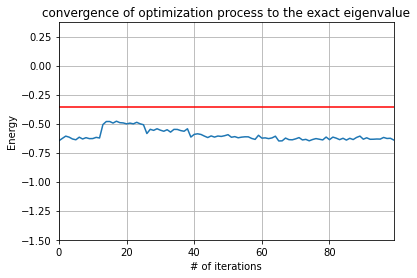

In [78]:
H2_approximated_energies = [-0.6479084750255486, -0.6276579569919597, -0.6079422008169065, -0.616731159779808, -0.6325842283091055, -0.6393897280901208, -0.6171807581727554, -0.632653791572579, -0.6213172282987715, -0.6295655663398093, -0.6289772030449229, -0.6186181091776035, -0.624022941533276, -0.5082839240612291, -0.48226570208794234, -0.4821361107003052, -0.4954020352078101, -0.4793435904590445, -0.49199670120300654, -0.49416478838441447, -0.502190052373643, -0.49599755978221166, -0.5020643548684793, -0.4889205213711024, -0.5018939914800866, -0.5099878400191491, -0.5856552068715944, -0.54923382599589, -0.5582306982767166, -0.5444314531693122, -0.5567710700669415, -0.5659113697818672, -0.552668511160273, -0.5735134318844516, -0.549852476753314, -0.5503189869962759, -0.5601864836520486, -0.5659896127460298, -0.5446950460298908, -0.615920984439197, -0.5928640404070656, -0.5879106801498322, -0.5935911543775607, -0.6075920247035514, -0.6201194518598445, -0.60623970115924, -0.6162790804378995, -0.6070899791213487, -0.6105620077787796, -0.604279338203177, -0.5953765787888684, -0.6176510100281449, -0.6121876903025966, -0.6221925707825862, -0.6167720694769763, -0.6138135616671906, -0.6141332165079305, -0.6280212409220817, -0.6360069982326235, -0.6007258601159454, -0.6251861183198779, -0.6230618384361196, -0.6294049945914133, -0.6233533946933156, -0.608497712991425, -0.6496414061454564, -0.6486467922145787, -0.6248046230879923, -0.6382435950247505, -0.6396933212611499, -0.6313975747684536, -0.6205882624714589, -0.6408121049037772, -0.6358325058878442, -0.6483418584555031, -0.6371649113759628, -0.6291839190391355, -0.6347573834032361, -0.6407098912056699, -0.6159176260854965, -0.6384554645835627, -0.6164080207309359, -0.625543079338974, -0.6382937503891668, -0.6264097132175528, -0.6420718561520969, -0.6267262725213436, -0.6374963711667498, -0.6193193504433864, -0.6078143278866533, -0.634472486357409, -0.6223512323012782, -0.6351163020561015, -0.634661177023637, -0.6327899211075433, -0.6336448686497769, -0.6193351633432258, -0.6281755978797693, -0.6264777231208046, -0.6414830476329384, -0.6307683399864691, -0.6307085701314388, -0.6206080402310008, -0.6348255969934301, -0.6396136598903551, -0.6119662685652434, -0.6416707355866279, -0.6413693107560723, -0.6177947197203094, -0.6298765228276698, -0.6523529064199631, -0.6449003109571184, -0.653383311719062, -0.6114270075961685, -0.6288547938898695, -0.618693644838608, -0.6474406100562011, -0.6311230491106903, -0.6116401562656182, -0.636431790506111, -0.6291838050229098, -0.6323232015973214, -0.6084567336875317, -0.6260410898582017, -0.6558980736383361, -0.6088478495140429, -0.6362772541154403, -0.6229687283270671, -0.6337477882049586, -0.6146890139542273, -0.6109822191193143, -0.6410668717503976, -0.6050360295204666, -0.6127109227117324, -0.613969481075047, -0.6330316470359499, -0.6336428860578563, -0.6579205656897767, -0.6226609914498723, -0.6308197002529959, -0.6592780043421462, -0.6286105470576249, -0.6142144474532307, -0.6308763800946607, -0.6313362339145869, -0.6587453552909762, -0.6439616021766039, -0.6342588475726809, -0.6348805630323535, -0.612208176680939, -0.6384209891698392, -0.6377259399102154, -0.6288355030414153, -0.6254287723561084, -0.6267028568621377, -0.633225553954038, -0.6266439989301029, -0.6219787315736918, -0.6444478946498267, -0.6078647889145464, -0.6169625336670495, -0.6228416937169068, -0.6055808453138738, -0.6349070986052844, -0.6233134657244299, -0.638807727216456, -0.6439324406558855, -0.6290682438485403, -0.6347278678305891, -0.6370807223116214, -0.6331202879928073, -0.6259391405710086, -0.6205239729014943, -0.6271330693467981, -0.6384914098927226, -0.6540996612097635, -0.6297277932870161, -0.6230026756130547, -0.6337458840743901, -0.6269616938156711, -0.6071713916280417, -0.6182364077263139, -0.6295847748388186, -0.6340000050667973, -0.662525648783056, -0.6268357485227919, -0.6383142008116837, -0.6356494637389134, -0.6334179386720562, -0.6368477711503842, -0.6258766827515051, -0.6250225216677815, -0.6402120922677865, -0.6215866553687236, -0.6300458164726813, -0.6349074242618946, -0.6281512038322912, -0.6106861518433435, -0.6257220729152266, -0.6264637065414248, -0.6413022282257185, -0.6287300650968061, -0.6415216331142828, -0.6177784438217981, -0.6235031629550336, -0.6522908854196745, -0.6433100700195024, -0.6467856500499529, -0.6383906423809346, -0.6353007399215785, -0.628267887248418, -0.6530534039557805, -0.6489154837903043, -0.6251303963665552, -0.606115215627397, -0.640564227336403, -0.6426262151446616, -0.6375465819155562, -0.6241657686495026, -0.6365874044036779, -0.6368987773426885, -0.6254336505997881, -0.6195698003196071, -0.6312797723656407, -0.6493745786523953, -0.6255032951930553, -0.6076271422511403, -0.6369485503847903, -0.633978893260772, -0.6247995690801257, -0.6181592078851024, -0.6413113581396256, -0.6357432503116383, -0.6413681655967249, -0.6349930744741815, -0.6553915345015394, -0.6333982709804692, -0.6323784240845362, -0.597462603561814, -0.6354799343741077, -0.6435513818689228, -0.6288306285283861, -0.6252986455639116, -0.6338258059332423, -0.6354797897494069, -0.6118871374772903]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-1.0051067048832336, margin=5)